<a href="https://colab.research.google.com/github/gadowks/FlipClock/blob/master/PUCP_class_02_chatbot_1_(ES).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clase 1**

# Descarga del modelo word2vec

In [13]:
#!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm #en_core_web_md
#!python -m spacy download en_core_web_lg

#Reiniciar el entorno de ejecución luego de descargar el modelo para que luego
#pueda ser cargado sin errores

     |████████████████████████████████| 11.1MB 733kB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.1.0-cp36-none-any.whl size=11111557 sha256=d63cbb3c524056340302980600b952af419694c5454f8c319ff6f61fac90a592
  Stored in directory: /tmp/pip-ephem-wheel-cache-y7vtxv8l/wheels/cc/ee/c4/68922955901918a9aaa82e828d4f7ee1ccfc861285277e79b7
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


# Descarga y carga de los stopwords

In [14]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
stopwords

# Limpieza de los stopwords en un texto

In [0]:
def remove_stopwords(text):
  text_filtered = ""
  for word in text.split():
    if word not in stopwords:
      text_filtered += word + " "
  return text_filtered

In [0]:
text = """When Sebastian Thrun started working on self-driving cars at 
        Google in 2007, few people outside of the company took him 
        seriously. “I can tell you very senior CEOs of major American 
        car companies would shake my hand and turn away because I wasn’t 
        worth talking to, said Thrun, in an interview with Recode earlier 
        this week."""

text = remove_stopwords(text)
text
#Quitamos las palabras que no generan valor, antes definidas en el stopword

'When Sebastian Thrun started working self-driving cars Google 2007, people outside company took seriously. “I tell senior CEOs major American car companies would shake hand turn away I wasn’t worth talking to, said Thrun, interview Recode earlier week. '

# Cargar el modelo de word2vec y transformar un texto a un vector

In [0]:
import spacy

#nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('es_core_news_sm') # #en_core_web_md
#nlp = spacy.load('en_core_web_lg')

In [0]:
#El modelo word2vec obtendrá los vectores de cada palabra en el texto y hará una suma ponderada de todos ellos para devolver 1 solo vector
vector = nlp(text).vector

#Mostramos solo los primeros 10 valores
# Ejemplo de vector de 2 dimensiones
#  distancia entre dos palabras sinonimas
#  [hi, hello]
vector[:2]

# Creamos un pequeño dataset de intents asociados a sentencias

In [0]:
# Una palabra que representa una intencion, la relacionamos
#*si
# ya
# vao
# dale

dataset = """
*Hola
Holas
Que hay
Habla
Que fue
Dime

*Comida
Quieres ir a comer
Vao a almorzar
Hamma
Richi

*Sip
ya
See
Claro
Vao

*Chau
Alamos
Nos vemos
Bella ciao
Bye bye
"""

# Entrenamos un modelo con nuestro dataset

## Métodos para crear el dataset

In [0]:
def filter_intents_and_their_examples(dataset, intent_character = "*"):
  filter_list = list(filter(None, dataset.split("\n")))

  intents_examples = {}
  intent = ""
  for element in filter_list:
    if element[0] == intent_character:
      intent = element[1:]
    else:
      if intent not in intents_examples:
        intents_examples[intent] = [element]
      else:
        intents_examples[intent].append(element)
  return intents_examples

def transform_examples_in_vectors(intents_examples, nlp):
  intents_vector_examples = {}
  for key, values in intents_examples.items():
    vector_examples = []
    for example in values:
      vector_examples.append(nlp(example).vector)
    
    intents_vector_examples[key] = vector_examples
  return intents_vector_examples

def create_x_and_y(intents_vector_examples):
  x = []
  y = []
  for label, vector_examples in intents_vector_examples.items():
    x.extend(vector_examples)
    y.extend([label] * len(vector_examples))
  
  return x, y

## Creando el dataset

In [0]:
#Obteniendo un diccionario de intents con sus sentencias
intents_examples = filter_intents_and_their_examples(dataset)

#Transformando las sentencias a vectores en el diccionario
intents_vector_examples = transform_examples_in_vectors(intents_examples, nlp)

#Obteniendo los nombres de los intents
intents = list(intents_vector_examples.keys())

#Obteniendo x,y para entrenar un modelo de Machine Learning
x, y = create_x_and_y(intents_vector_examples)

In [6]:
intents_examples['Hola']

['Holas', 'Que hay', 'Habla', 'Que fue', 'Dime']

In [7]:
intents

['Hola', 'Comida', 'Sip', 'Chau']

## Entrenando el modelo de Machine Learning

In [8]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(x, y)

#Evaluacion del accuracy
accuracy = decision_tree_classifier.score(x, y)
accuracy

1.0

## Visualización del árbol

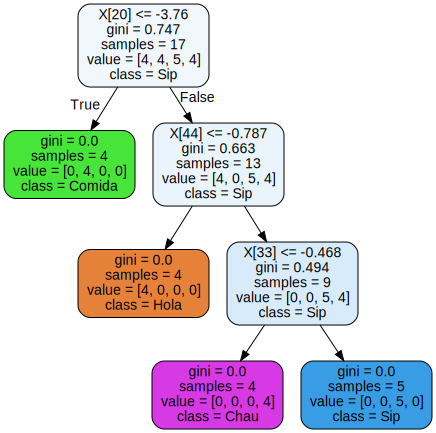

In [9]:
from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(decision_tree_classifier,
                                out_file=None,
                                class_names=intents,
                                filled=True,
                                rounded=True)
graph = graphviz.Source(dot_data)
graph

# Creamos un módulo que use nuestro modelo para predecir los intents

## Método que representa nuestro módulo

In [0]:
def predict_intent(sentence, nlp, model):
  vector = nlp(sentence).vector
  
  intent = model.predict([vector])
  return intent[0]

## Probamos nuestro modulo

In [12]:
sentence = "hola"
intent = predict_intent(sentence, nlp, decision_tree_classifier)
intent

'Chau'

# Probando las predicciones de nuestro bot

In [13]:
while True:
  sentence = input()
  if sentence == "/quit":
    break
  
  intent = predict_intent(sentence, nlp, decision_tree_classifier)
  print("bot predict: {}\n".format(intent))
  if intent == "Chau":
    break

Hola
bot predict: Sip

comida
bot predict: Sip

Comida
bot predict: Sip

Chau
bot predict: Sip

Alamos
bot predict: Chau



# Creamos un pequeño dataset de utterances asociados a sentencias

In [0]:
dataset = """
*Hola
Holas
Que hay
Habla
Que fue
Dime

*Comida
Quieres ir a comer
Vao a almorzar
Hamma
Richi

*Sip
ya
See
Claro
Vao

*Chau
Alamos
Nos vemos
Bella ciao
Bye bye
"""

## Métodos para crear el dataset

In [0]:
def filter_utterances_and_their_examples(dataset, utterance_character = "*"):
  filter_list = list(filter(None, dataset.split("\n")))

  utterances_examples = {}
  utterance = ""
  for element in filter_list:
    if element[0] == utterance_character:
      utterance = element[1:]
    else:
      if utterance not in utterances_examples:
        utterances_examples[utterance] = [element]
      else:
        utterances_examples[utterance].append(element)
  return utterances_examples

## Creando el dataset

In [16]:
#Obteniendo un diccionario de utterances con sus sentencias
utterances_examples = filter_utterances_and_their_examples(dataset)
utterances_examples

{'Chau': ['Alamos', 'Nos vemos', 'Bella ciao', 'Bye bye'],
 'Comida': ['Quieres ir a comer', 'Vao a almorzar', 'Hamma', 'Richi'],
 'Hola': ['Holas', 'Que hay', 'Habla', 'Que fue', 'Dime'],
 'Sip': ['ya', 'See', 'Claro', 'Vao']}

## Definimos las reglas intent - utterance

In [0]:
rules = {
    "Hola": "Hola",
    "Comida": "Comida",
    "Sip": "Sip",
    "Chau": "Chau"
}

# Creamos un módulo que genere lo que el bot va responder

## Método que representa nuestro módulo

In [0]:
from random import choice

def generate_answer(utterance, utterances_examples):
  answers = utterances_examples[utterance]
  answer = choice(answers)
  return answer

## Probamos nuestro modulo

In [19]:
utterance = "Hola"
answer_1 = generate_answer(utterance, utterances_examples)
answer_2 = generate_answer(utterance, utterances_examples)
answer_1, answer_2

('Que hay', 'Habla')

# Creamos el módulo para conversar con el bot

## Método que representa nuestro módulo

In [0]:
def return_answer(sentence, nlp, model, rules, utterances_examples):
  intent = predict_intent(sentence, nlp, decision_tree_classifier)
  
  utterance = rules[intent]
  
  answer = generate_answer(utterance, utterances_examples)
  return answer, intent

## Probamos chatear con nuestro bot

In [23]:
while True:
  sentence = input()
  if sentence == "/quit":
    break
  
  answer, intent = return_answer(sentence, nlp, decision_tree_classifier, rules, utterances_examples)
  print("bot says: {}\n".format(answer))
  if intent == "Chau":
    break

Hola
bot says: ya

Holas
bot says: Que fue

Hamma
bot says: Quieres ir a comer

ya
bot says: See

alamos
bot says: Bye bye

